# 1.󠀠󠀮󠁽󠁝󠁝󠁝󠁝 Notebook Overview
## Background
Text and image embeddings are just vectors of numbers (say a 512x1 vector) learned by a model, that capture the gist of a sentence or a picture.

Instead of raw pixels or words, each point in the vector encodes a bit of meaning—so two text strings that “feel” similar in meaning end up with vectors that sit close together, and the same goes for visually similar images.

## Contrastive Language-Image Pretraining (CLIP)
enables us to create embeddings for text strings as well as images in a shared embedding space. In this shared embedding space the vector for an image, and
the vector of the text description of the image will be close to one another. For example, the image of the cat and the text string "a cat" will be encoded
into 512x1 vectors, and these vectors will be close to one another compared to an unrelated text string like "an airplane"

## Goals
In this notebook we willl learn how to use CLIP to do the following.

Learn how to obtain embedding for a text string.
Compare embeddings of different text strings.
Learn how to obtain embedding for an image.
Compare embeddings of different images.
Compare embeddings of images and text strings.

# 2. Imports

In [1]:
# Install transformers library, which contains pre-trained models for NLP and computer vision tasks
!pip install transformers

# Import necessary libraries

from transformers import CLIPTokenizer # Tokenizer for the CLIP model, converts text into tokens
from transformers import CLIPProcessor # Preprocessor for CLIP model, handles image/text preprocessing
from transformers import CLIPModel     # CLIP model for image-text embedding and similarity tasks

import torch                           # PyTorch library, used for tensor operations and GPU computations
import torch.nn.functional as F        # Contains functional API for neural network operations (e.g., activations, loss functions)
import numpy as np                     # Numerical library for array manipulation and computations

import matplotlib.pyplot as plt        # Library for plotting images and visualizations
import seaborn as sns                  # Library for creating statistical visualizations

from PIL import Image                  # Used for loading and processing images
import requests                        # Used to fetch images from URLs
from io import BytesIO                 # Enables reading binary data as file-like objects in memory

2025-09-18 20:20:05.775080: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758226806.166236      60 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758226806.276636      60 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 3. Load Model

In [2]:
# Define the model name for the CLIP variant (Vision Transformer - base, 32x32 patches)
model_name = "openai/clip-vit-base-patch32"

# Load the pre-trained CLIP model from Hugging Face
model = CLIPModel.from_pretrained(model_name)

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

# 4. Tokenize Text Strings

In [3]:
# Load the tokenizer associated with the specified CLIP model
tokenizer = CLIPTokenizer.from_pretrained(model_name)

# Define a list of text descriptions to embed
text = ["a bird", "a crow", "a car", "a bus"]

# Tokenize and preprocess the text inputs with padding to ensure equal sequence lengths
inputs = tokenizer(text, padding=True, return_tensors="pt")

# Unpack the inputs
input_ids = inputs.input_ids  # Tokenized and encoded text input IDs

# Print information about the unpacked inputs
print("Input IDs (shape):", input_ids.shape)
print(input_ids)

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Input IDs (shape): torch.Size([4, 4])
tensor([[49406,   320,  3329, 49407],
        [49406,   320, 16019, 49407],
        [49406,   320,  1615, 49407],
        [49406,   320,  2840, 49407]])


# 5.󠀠󠀮󠁽󠁝󠁝󠁝󠁝 Find Text Embeddings

## The CLIP model takes in tokenized strings and returns an 512 length embedding for every string.

In [4]:
# Compute text embeddings without tracking gradients (inference mode)
with torch.no_grad():
    # Obtain text embeddings (feature vectors) from the CLIP model
    text_embeddings = model.get_text_features(**inputs) #(** is used for unzipping )
    # Outputsdense vector embeddings for each text input. These embeddings live in the same space as image embeddings → so you can directly compare images and texts via cosine similarity.

print(text_embeddings.shape)
# Print the shape of the resulting text embeddings tensor
# The shape is [number_of_texts, embedding_dimension]

torch.Size([4, 512])


# 6.󠀠󠀮󠁽󠁝󠁝󠁝󠁝 Calculate Cosine Similarity

### Why did the two vectors start dating after math class?

### Because when they calculated their cosine similarity, they realized they were practically aligned—it was love at first dot-product!

**Cosine similarity** measures how similar (aligned) two vectors are by looking only at the angle between them, not their length.

* Cosine Similarity - https://www.youtube.com/watch?v=zcUGLp5vwaQ
* Imagine each vector as an arrow from the origin.
* The cosine of the angle \$\theta\$ between the arrows is

$$
\operatorname{cosine\_sim}(\mathbf{a}, \mathbf{b}) \;=\; \cos(\theta) \;=\;
\frac{\mathbf{a}\cdot\mathbf{b}}
     {\lVert\mathbf{a}\rVert\,\lVert\mathbf{b}\rVert}
$$

* A value of **+1** means the arrows point in exactly the same direction (perfect similarity), **0** means they’re orthogonal (no similarity), and **–1** means they point in opposite directions (complete dissimilarity).

### Because it ignores magnitude, cosine similarity is ideal for comparing text or image embeddings where direction captures meaning and length may just scale with word count or pixel intensity.

The calculated cosine similarity between strings are displayed using a color coded matrix.

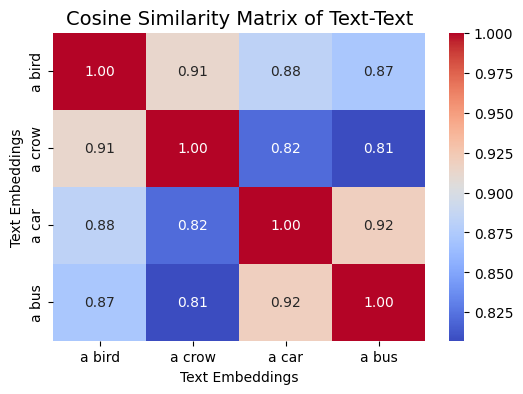

In [5]:
# Text_embeddings is a tensor of shape [n, d], where:
# - n = number of text prompts
# - d = embedding dimension

# Compute the n x n cosine similarity matrix between all pairs of embeddings
# text_embeddings[:, None, :] reshapes embeddings to [n, 1, d]
# text_embeddings[None, :, :] reshapes embeddings to [1, n, d]
# cosine_similarity calculates similarity along the last dimension (d)
cosine_similarity = F.cosine_similarity(
    text_embeddings[:, None, :],    # Shape: [n, 1, d]
    text_embeddings[None, :, :],    # Shape: [1, n, d]
    dim=2                           # Calculate similarity along embedding dimension d
).cpu().numpy()                     # Move to CPU and convert tensor to NumPy array for plotting

# Initialize a matplotlib figure with specified size (width=6, height=4)
plt.figure(figsize=(6, 4))

# Create a heatmap visualization using seaborn to display the cosine similarity matrix
sns.heatmap(
    cosine_similarity,              # Matrix to visualize (n x n similarity scores)
    annot=True,                     # Annotate each cell with numeric similarity value
    fmt=".2f",                      # Format annotations to two decimal places
    cmap="coolwarm",                # Colormap for heatmap indicating negative/positive similarities
    xticklabels=text,               # Label x-axis with the original text prompts
    yticklabels=text                # Label y-axis with the original text prompts
)

# Set the plot title with font size 14
plt.title("Cosine Similarity Matrix of Text-Text", fontsize=14)

# Label x-axis as "Text Embeddings"
plt.xlabel("Text Embeddings")

# Label y-axis as "Text Embeddings"
plt.ylabel("Text Embeddings")

# Display the plot
plt.show()

# 7.󠀠󠀮󠁽󠁝󠁝󠁝󠁝 Plot Images

In [6]:
# Utility function for displaying images with labels
def plot_images(images, labels):
    n = len(images) # Number of images loaded successfully
    fig, axes = plt.subplots(1, n, figsize=(12, 4))  # figsize to avoid overlap
    # Loop through each subplot axis, image, and its label to display them
    for ax, img, lbl in zip(axes, images, labels):
        ax.imshow(img)              # Display the image on the axis
        ax.set_title(lbl)           # Set the title of the subplot to the image label
        ax.axis("off")              # Turn off axis ticks and labels for clarity
    plt.tight_layout()
    plt.show()

# 8.󠀠󠀮󠁽󠁝󠁝󠁝󠁝 Load and Display Images

In [7]:
# Load a pre-trained CLIP processor for handling images and text preprocessing
processor = CLIPProcessor.from_pretrained(model_name)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

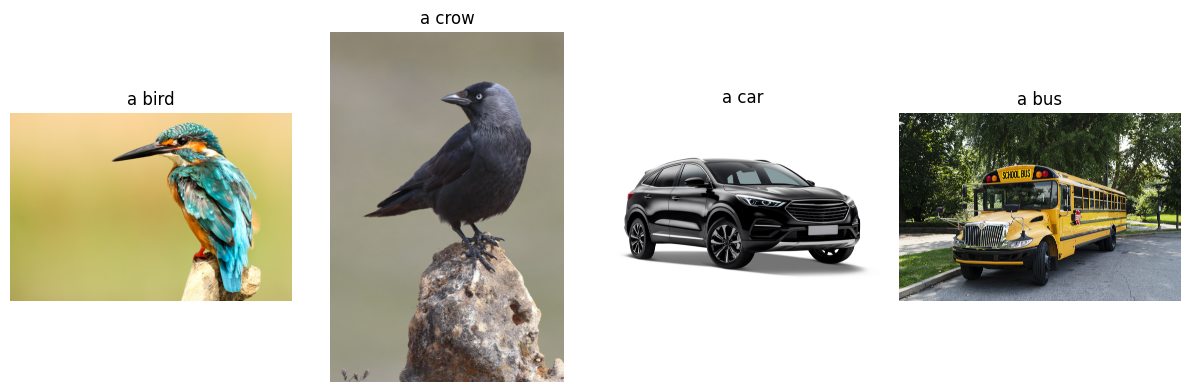

In [8]:
import os
from PIL import Image
import matplotlib.pyplot as plt


# Dictionary containing labels and their corresponding local image paths
image_urls = {
    "a bird": "/kaggle/input/vlm-sample-image/VLM_Dataset_Sample/Bird_image.jpg",
    "a crow": "/kaggle/input/vlm-sample-image/VLM_Dataset_Sample/Crow_image.jpg",
    "a car": "/kaggle/input/vlm-sample-image/VLM_Dataset_Sample/Car_image.jpeg",
    "a bus": "/kaggle/input/vlm-sample-image/VLM_Dataset_Sample/Bus_image.jpg"
}

# Extract the list of labels
labels = list(image_urls.keys())

# Function to load local images safely
def load_image(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    return Image.open(path).convert("RGB")

# Initialize list of images
images = []

# Loop through each label and load images
for label in labels:
    try:
        img = load_image(image_urls[label])
        images.append(img)
    except Exception as e:
        print(f"Failed to load {label}: {e}")

# Display the images
plot_images(images, labels)

# 9.󠀠󠀮󠁽󠁝󠁝󠁝󠁝 Calculate Image Emdeddings & Display Similarity

torch.Size([4, 512])


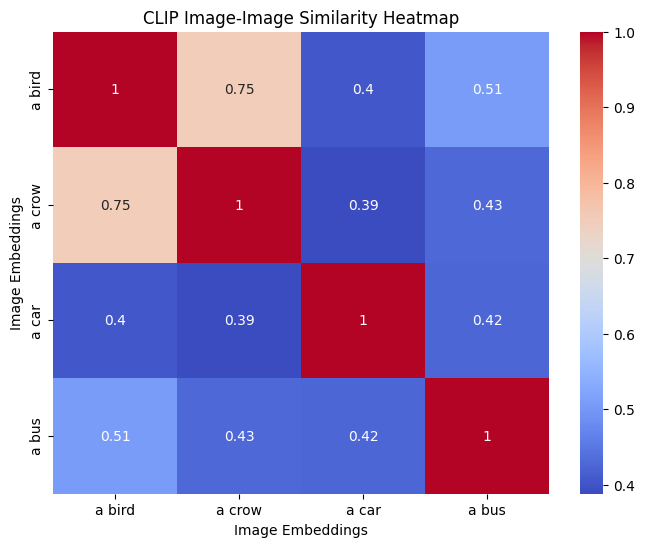

In [9]:
# Preprocess images using CLIP processor to prepare for embedding generation
image_inputs = processor(images=images, # images stores the 4 photos above
                         return_tensors="pt" # returns a pytorch tensor
                        ) # this does resize, normalization, and returns a tensor

with torch.no_grad():
  # Generate image embeddings using the CLIP model
  image_embeddings = model.get_image_features(**image_inputs)

# Print the shape of the resulting image embeddings tensor
# The shape is [number_of_images, embedding_dimension]
print(image_embeddings.shape)

# Compute similarity matrix
img_similarity = F.cosine_similarity(image_embeddings[:, None, :], 
                                     image_embeddings[None, :, :], 
                                     dim=2).cpu().numpy()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(img_similarity, annot=True, xticklabels=labels, yticklabels=labels, cmap="coolwarm")
plt.xlabel("Image Embeddings")
plt.ylabel("Image Embeddings")
plt.title("CLIP Image-Image Similarity Heatmap")
plt.show()

# 10.󠀠󠀮󠁽󠁝󠁝󠁝󠁝 Calculate Image-Text Similarity

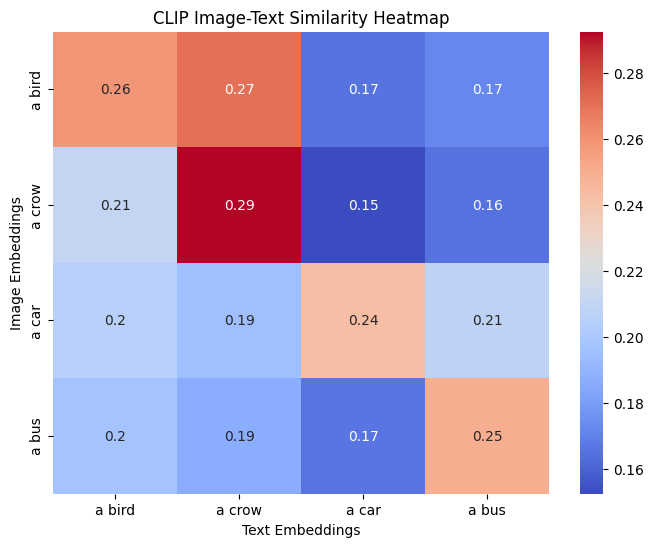

In [10]:
# Compute similarity matrix
txt_image_similarity = F.cosine_similarity(
                            text_embeddings[:, None, :],
                            image_embeddings[None, :,:], 
                            dim=2).cpu().numpy()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(txt_image_similarity, annot=True, xticklabels=labels, yticklabels=labels, cmap="coolwarm")
plt.xlabel("Text Embeddings")
plt.ylabel("Image Embeddings")
plt.title("CLIP Image-Text Similarity Heatmap")
plt.show()

# Findings - 

## 1. Bird and Crow are quite close to each other
## 2. Car and Bus are quite close to each other
## 3. Bird and Car are distant from each other